<a href="https://colab.research.google.com/github/foxtrotmike/cafemap/blob/master/cafemap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Context Aware Feature Mapping
### By
## Fayyaz Minhas

How can we find discriminatory features between two classes? What is the relative importance of each feature for a given task? What if you have tens of thousands of features? How can we reliably find the features that are important?
These questions have been asked and answered in the literature with a number of feature selection and dimensionality reduction techniques such as Principal Component Analysis, Recursive Feature Elimination, etc. Feature selection and ranking is of great importance in analysis of biomedical data. In addition to reducing the number of features used in classification or other machine learning tasks, it allows us to extract meaningful biological and medical information from a machine learning model. Most existing approaches in this domain do not directly model the fact that the relative importance of features can be different in different regions of the feature space. In this work, we present a context aware feature ranking algorithm called [CAFÉ-Map](https://www.sciencedirect.com/science/article/pii/S001048251630258X) . CAFÉ-Map is a locally linear feature ranking framework that allows recognition of important features in any given region of the feature space or for any individual example. This allows for simultaneous classification and feature ranking in an interpretable manner. We have benchmarked CAFÉ-Map on a number of toy and real world biomedical data sets. Our comparative study with a number of published methods shows that CAFÉ-Map achieves better accuracies on these data sets. The top ranking features obtained through CAFÉ-Map in a gene profiling study correlate very well with the importance of different genes reported in the literature. Furthermore, CAFÉ-Map provides a more in-depth analysis of feature ranking at the level of individual examples. 

##Why Context Aware Feature Mapping?

Existing feature selection techniques do not provide ranking or selection of features for individual instances. Typically, these approaches identify features which are important at the global level. To the best knowledge of the authors, no previously published feature selection or ranking technique has the ability to identify important features in individual training and test examples in a context aware or local manner. We illustrate the motivation behind this idea with an illustrative example in the Figure below. 
![picture](https://drive.google.com/uc?id=1jNGWarJGBOzDDM80kd2FKO83q-3hlpR6)

For this simple L-shaped synthetic data set comprising of two classes, any existing feature selection technique will rank both features as important. However, it is interesting to notice that the relative importance of the two features for correct classification is dependent upon the local context as well. For instance, along the vertical part of the classification boundary in this figure, feature $x_1$ is more important in comparison to feature $x_2$. Similarly, along the horizontal component of the classification boundary, feature $x_2$ is responsible for discrimination.  Though most existing feature selection techniques implicitly consider the fact that the role of a given feature in determining the classification boundary varies over different parts of the feature space, their output cannot be interpreted in such a manner. Context aware feature selection or ranking can lead to a more detailed analysis of the roles of different features in different parts of the feature space as well as in identifying what features are relatively more important in comparison to others for individual examples. 

The novelty of CAFÉ-Map comes from its unique ability to quantify the relative importance of features in any region of the feature space. This is achieved by associating a local or context aware weight vector with each classification example. The mathematical and algorithmic formulation of CAFÉ-Map leads to the selection of a minimal set of local or context dependent features for every individual example while ensuring high classification accuracy, computational efficiency and interpretability. CAFÉ-Map is strongly grounded in the theory of Structural Risk Minimization and is designed to handle the challenges of biomedical data.


## How CAFE-Map solves the issue?

Similar to a SVM, CAFE-Map uses a decision function $f(x)=w^Tx$. However, CAFE-Map uses a context-aware weight vector $w(x)$ for each individual example $x$ as opposed to a global weight vector as used in  SVMs. The magnitude of the components of the weight vector $w(x)$ indicate the relative importance of different features for a given example. 

The Figure below shows the results of applying CAFÉ-Map on the L-shaped toy data set discussed earlier. It is evident that CAFÉ-Map is able to find a highly accurate classification boundary (Figure 2(a)). The analysis of the absolute values of the local weights $w(x)$ in different regions of the feature space shows their relative importance. It is clear that different features are important in different regions of the feature space with $|w_1 (x)|$ being higher than $|w_2 (x)|$ along the vertical decision boundary and vice versa. This allows us to analyze the importance of each feature for any given example.
![picture](https://drive.google.com/uc?id=1jNocHePQW9uEcQL6DjCgOUg6r-jwh_ki)

## CAFE-Map under the hood
CAFE-Map obtains its context-aware weight vector function by using locally linear coding which represents a given example $x$ in terms of sparse vector of local coordinates $\gamma(x)$ relative to an a priori selected set of $K$ anchor points. These anchor points are selected from the given dataset by random selection or K-means. The sparseness of the local coordinate representation can be controlled by a regularization parameter $\gamma$. The learning problem is then solved in the local coordinate space by using a structural risk minimization involveing another regularization parameter $\lambda$ that aims at reducing the magnitude of the local weight vectors. 

## How to use CAFE-Map to find what makes a 9 different from a 5?
CAFE-Map can be easy installed using pip and it allows easy extraction of feature importance. The code below demonstrates the use of CAFE-Map for the task of classifying digits 5 and 9 in MNIST and then showing the local weight vectors as images. It is easy to see that it is possible to classify between these two digits based on which pixels are turned on in an image! Can you find which ones?

More test cases are discussed in the CAFE-Map paper. 

In [1]:
!pip install cafemap

Number of Clusters (10, 64)


/usr/local/lib/python3.6/dist-packages/cafemap/llc.py:109: UserWarning: k set to 10.
  warnings.warn('k set to %d.' % c)


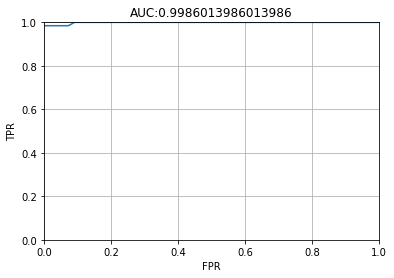

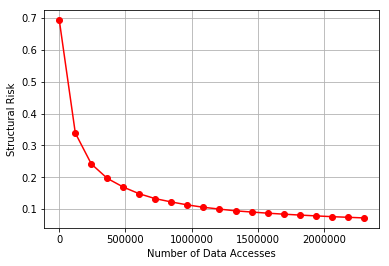

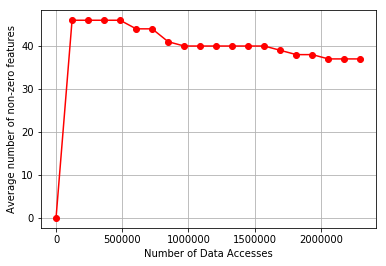

<Figure size 432x288 with 0 Axes>

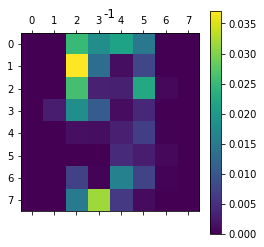

<Figure size 432x288 with 0 Axes>

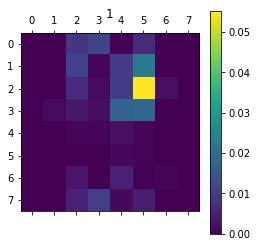

In [10]:
import numpy as np
from cafemap import *
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split


#Load MNIST with 9's as the positive class and 5's as the negative
digits = load_digits(n_class=10)
Y = digits.target
X = digits.data
c1 = 9
c2 = 5
X = X[(Y==c1)+(Y==c2)]
Y = Y[(Y==c1)+(Y==c2)]
Y = 2*(Y==c1)-1
#Perform the train-test split
X, Xv, Y, Yv = train_test_split(X, Y, test_size=0.33, random_state=42)

# Standardize the data to unit norm
X = (X.T/np.linalg.norm(X,axis=1)).T
Xv = (Xv.T/np.linalg.norm(Xv,axis=1)).T    

# Change examples to internal data structure of CAFE-Map
I = createInstances(X, Y)
Iv = createInstances(Xv, Yv)

# Obtain local coordinate representation with 10 anchor points
llc = compute_gammas(I+Iv, K=10,  gamma=1e-1)

# Train the classifier
classifier = cafeMap(Lambda = 5e-3)
classifier.train(I, history = 500)

# Test the classifier
scores = np.array(classifier.test(Iv))

# Obtain ROCs
fpr,tpr,auc = roc(list(scores),list(Yv)) 
plt.figure()
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.axis([0,1,0,1])
plt.grid()
plt.title('AUC:'+str(auc))    

# Plot convergence plot of the classifier
plotConvergence(classifier)


#Plot local weight vectors
D = {}
for i in Iv:
    if i.label not in D:
        D[i.label]=[]

    else:
        f = classifier.W.dot(i.gammas) #obtain local weight vector
        D[i.label].append(f)
for k in D:
    f = np.mean(D[k],axis=0)
    plt.figure()
    plt.matshow(np.abs(f).reshape((8,8)))
    plt.colorbar()
    plt.title(k)